# SimpleImgClassifier
Use TensorFlow to recognize between two classes of objects.

## Classify Target: Monkey Species Dataset
I choose to train a classifier to recognize between two different monkey species by using TensorFlow.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from tensorflow import keras

The Monkey Species Dataset was downloaded from https://www.kaggle.com/slothkong/10-monkey-species.  
It provides 10 different monkey species' images:

In [2]:
file_path = os.getcwd()
labels_path = os.path.join(file_path, r'images\10-monkey-species\monkey_labels.txt')
table = pd.read_table(labels_path, sep='\s*,\s*', engine='python')
table

,Label,Latin Name,Common Name,Train Images,Validation Images
0,n0,alouatta_palliata,mantled_howler,131,26
1,n1,erythrocebus_patas,patas_monkey,139,28
2,n2,cacajao_calvus,bald_uakari,137,27
3,n3,macaca_fuscata,japanese_macaque,152,30
4,n4,cebuella_pygmea,pygmy_marmoset,131,26
5,n5,cebus_capucinus,white_headed_capuchin,141,28
6,n6,mico_argentatus,silvery_marmoset,132,26
7,n7,saimiri_sciureus,common_squirrel_monkey,142,28
8,n8,aotus_nigriceps,black_headed_night_monkey,133,27
9,n9,trachypithecus_johnii,nilgiri_langur,132,26


choose white_headed_capuchin(label=n5) and japanese_macaque(label=n3) as the two species to recognize.

In [3]:
# white_headed_capuchin = tabel['Label']
# japanese_macaque = table['Label']
white_headed_capuchin = table.loc[table[table['Common Name'] == 'white_headed_capuchin'].index[0]]['Label']
japanese_macaque = table.loc[table[table['Common Name'] == 'japanese_macaque'].index[0]]['Label']

In [4]:
training_dir = os.path.join(file_path, r'images\10-monkey-species\training')
whc_train_dir = os.path.join(training_dir, white_headed_capuchin)
jm_train_dir = os.path.join(training_dir, japanese_macaque)

whc_train_images_list = [os.path.join(whc_train_dir, f) for f in os.listdir(whc_train_dir) 
                  if os.path.isfile(os.path.join(whc_train_dir, f)) and f.endswith('.jpg')]

jm_train_images_list = [os.path.join(jm_train_dir, f) for f in os.listdir(jm_train_dir) 
                  if os.path.isfile(os.path.join(jm_train_dir, f)) and f.endswith('.jpg')]

In [5]:
test_dir = os.path.join(file_path, r'images\10-monkey-species\validation')
whc_test_dir = os.path.join(training_dir, white_headed_capuchin)
jm_test_dir = os.path.join(training_dir, japanese_macaque)

whc_test_images_list = [os.path.join(whc_test_dir, f) for f in os.listdir(whc_test_dir) 
                  if os.path.isfile(os.path.join(whc_test_dir, f)) and f.endswith('.jpg')]

jm_test_images_list = [os.path.join(jm_test_dir, f) for f in os.listdir(jm_test_dir) 
                  if os.path.isfile(os.path.join(jm_test_dir, f)) and f.endswith('.jpg')]

In [6]:
# train_images = tf.constant(whc_train_images_list+jm_train_images_list)
# train_labels = tf.constant([1.0 for _ in whc_train_images_list]+[0.0 for _ in jm_train_images_list])
# test_images = tf.constant(whc_test_images_list+jm_test_images_list)
# test_labels = tf.constant([1.0 for _ in whc_test_images_list]+[0.0 for _ in jm_test_images_list])
train_filenames = whc_train_images_list + jm_train_images_list

train_labels = [1 for _ in whc_train_images_list] + [0 for _ in jm_train_images_list]

test_filenames = whc_test_images_list + jm_test_images_list

test_labels = [1 for _ in whc_test_images_list] + [0 for _ in jm_test_images_list]

In [23]:
def parse_function(filename, label):
    image_string = tf.read_file(filename)
    decoded_image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(decoded_image, tf.float32)
    resized_image = tf.image.resize_images(image, [64, 64])
    
    label = tf.one_hot(label, 2, axis=0)
    return resized_image, label

In [54]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_filenames, train_labels))
train_dataset = train_dataset.shuffle(buffer_size=len(train_filenames))
train_dataset = train_dataset.map(parse_function)
train_dataset = train_dataset.batch(100)
train_dataset = train_dataset.prefetch(1)

In [55]:
test_dataset = tf.data.Dataset.from_tensor_slices((test_filenames, test_labels))
test_dataset = test_dataset.shuffle(buffer_size=len(test_filenames))
test_dataset = test_dataset.map(parse_function)
test_dataset = test_dataset.batch(100)
test_dataset = test_dataset.prefetch(1)

In [56]:
iterator = train_dataset.make_initializable_iterator()
images, labels = iterator.get_next()
iterator_init_op = iterator.initializer
inputs = {'images': images, 'labels': labels, 'iterator_init_op': iterator_init_op}

In [57]:
test_iter = test_dataset.make_initializable_iterator()
test_images, test_labels = test_iter.get_next()
test_init_op = test_iter.initializer

In [36]:
# check data
results = []
with tf.Session() as sess:
    sess.run(iterator_init_op)
    for i in range(int(len(train_filenames)/100) + 1):
        results.append(sess.run(labels))

In [81]:
num_batches = int(len(train_filenames) / 100)
last_batch_size = len(train_filenames) % 100
if last_batch_size != 0:
    num_batches += 1
num_epochs = 100

In [86]:
num_batches = int(len(test_filenames) / 100)
last_batch_size = len(test_filenames) % 100
if last_batch_size != 0:
    num_batches += 1
num_epochs = 100

In [82]:
images = inputs['images']
images = tf.reshape(images, [-1, 64*64*3])
net_l1 = tf.layers.dense(images, 25, activation=tf.nn.relu)
net_l2 = tf.layers.dense(net_l1, 12, activation=tf.nn.relu)
logits = tf.layers.dense(net_l2, 2, activation=tf.nn.softmax)

labels = inputs['labels']
labels = tf.cast(labels, tf.int64)
correct_predictions = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
accuracy = tf.reduce_mean(tf.cast(correct_predictions, 'float'))

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
optimizer = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(loss)

In [83]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
for epoch in range(num_epochs):
    sess.run(iterator_init_op)
    epoch_cost = 0.
    for i in range(num_batches):
        _, loss_val = sess.run([optimizer, loss])
        if i == num_batches - 1 and last_batch_size != 0:
            epoch_cost += loss_val / last_batch_size
        else:
            epoch_cost += loss_val / 100
    if epoch%100 == 0:
        print("Cost after epoch %i: %f" % (epoch, epoch_cost))

Cost after epoch 0: 0.033159


In [85]:
sess.run(iterator_init_op)
accuracy_val = 0.
for i in range(num_batches):
    result = sess.run(accuracy)
    if i == num_batches - 1 and last_batch_size != 0:
        accuracy_val += result * last_batch_size / len(train_filenames)
    else:
        accuracy_val += result * 100 / len(train_filenames)
accuracy_val

1.0

In [87]:
images = test_images
labels = test_labels
images = tf.reshape(images, [-1, 64*64*3])
net_l1 = tf.layers.dense(images, 25, activation=tf.nn.relu)
net_l2 = tf.layers.dense(net_l1, 12, activation=tf.nn.relu)
logits = tf.layers.dense(net_l2, 2, activation=tf.nn.softmax)

labels = inputs['labels']
labels = tf.cast(labels, tf.int64)
correct_predictions = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
accuracy = tf.reduce_mean(tf.cast(correct_predictions, 'float'))

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
optimizer = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(loss)

In [88]:
sess.run(test_init_op)
accuracy_val = 0.
for i in range(num_batches):
    result = sess.run(accuracy)
    if i == num_batches - 1 and last_batch_size != 0:
        accuracy_val += result * last_batch_size / len(test_filenames)
    else:
        accuracy_val += result * 100 / len(test_filenames)
accuracy_val

FailedPreconditionError: Attempting to use uninitialized value dense_24/kernel
	 [[{{node dense_24/kernel/read}} = Identity[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](dense_24/kernel)]]

Caused by op 'dense_24/kernel/read', defined at:
  File "C:\Users\46176\Anaconda3\lib\runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\46176\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "c:\users\46176\documents\files\study\ec601\project02\venv\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "c:\users\46176\documents\files\study\ec601\project02\venv\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "c:\users\46176\documents\files\study\ec601\project02\venv\lib\site-packages\ipykernel\kernelapp.py", line 505, in start
    self.io_loop.start()
  File "c:\users\46176\documents\files\study\ec601\project02\venv\lib\site-packages\tornado\platform\asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\46176\Anaconda3\lib\asyncio\base_events.py", line 345, in run_forever
    self._run_once()
  File "C:\Users\46176\Anaconda3\lib\asyncio\base_events.py", line 1312, in _run_once
    handle._run()
  File "C:\Users\46176\Anaconda3\lib\asyncio\events.py", line 125, in _run
    self._callback(*self._args)
  File "c:\users\46176\documents\files\study\ec601\project02\venv\lib\site-packages\tornado\ioloop.py", line 758, in _run_callback
    ret = callback()
  File "c:\users\46176\documents\files\study\ec601\project02\venv\lib\site-packages\tornado\stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "c:\users\46176\documents\files\study\ec601\project02\venv\lib\site-packages\tornado\gen.py", line 1233, in inner
    self.run()
  File "c:\users\46176\documents\files\study\ec601\project02\venv\lib\site-packages\tornado\gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "c:\users\46176\documents\files\study\ec601\project02\venv\lib\site-packages\ipykernel\kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "c:\users\46176\documents\files\study\ec601\project02\venv\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "c:\users\46176\documents\files\study\ec601\project02\venv\lib\site-packages\ipykernel\kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "c:\users\46176\documents\files\study\ec601\project02\venv\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "c:\users\46176\documents\files\study\ec601\project02\venv\lib\site-packages\ipykernel\kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "c:\users\46176\documents\files\study\ec601\project02\venv\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "c:\users\46176\documents\files\study\ec601\project02\venv\lib\site-packages\ipykernel\ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "c:\users\46176\documents\files\study\ec601\project02\venv\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "c:\users\46176\documents\files\study\ec601\project02\venv\lib\site-packages\IPython\core\interactiveshell.py", line 2817, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "c:\users\46176\documents\files\study\ec601\project02\venv\lib\site-packages\IPython\core\interactiveshell.py", line 2843, in _run_cell
    return runner(coro)
  File "c:\users\46176\documents\files\study\ec601\project02\venv\lib\site-packages\IPython\core\async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "c:\users\46176\documents\files\study\ec601\project02\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3018, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "c:\users\46176\documents\files\study\ec601\project02\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3183, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "c:\users\46176\documents\files\study\ec601\project02\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3265, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-87-c44c294487ae>", line 4, in <module>
    net_l1 = tf.layers.dense(images, 25, activation=tf.nn.relu)
  File "c:\users\46176\documents\files\study\ec601\project02\venv\lib\site-packages\tensorflow\python\layers\core.py", line 184, in dense
    return layer.apply(inputs)
  File "c:\users\46176\documents\files\study\ec601\project02\venv\lib\site-packages\tensorflow\python\keras\engine\base_layer.py", line 828, in apply
    return self.__call__(inputs, *args, **kwargs)
  File "c:\users\46176\documents\files\study\ec601\project02\venv\lib\site-packages\tensorflow\python\layers\base.py", line 364, in __call__
    outputs = super(Layer, self).__call__(inputs, *args, **kwargs)
  File "c:\users\46176\documents\files\study\ec601\project02\venv\lib\site-packages\tensorflow\python\keras\engine\base_layer.py", line 759, in __call__
    self.build(input_shapes)
  File "c:\users\46176\documents\files\study\ec601\project02\venv\lib\site-packages\tensorflow\python\keras\layers\core.py", line 921, in build
    trainable=True)
  File "c:\users\46176\documents\files\study\ec601\project02\venv\lib\site-packages\tensorflow\python\layers\base.py", line 278, in add_weight
    getter=vs.get_variable)
  File "c:\users\46176\documents\files\study\ec601\project02\venv\lib\site-packages\tensorflow\python\keras\engine\base_layer.py", line 586, in add_weight
    aggregation=aggregation)
  File "c:\users\46176\documents\files\study\ec601\project02\venv\lib\site-packages\tensorflow\python\training\checkpointable\base.py", line 591, in _add_variable_with_custom_getter
    **kwargs_for_getter)
  File "c:\users\46176\documents\files\study\ec601\project02\venv\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 1484, in get_variable
    aggregation=aggregation)
  File "c:\users\46176\documents\files\study\ec601\project02\venv\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 1234, in get_variable
    aggregation=aggregation)
  File "c:\users\46176\documents\files\study\ec601\project02\venv\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 538, in get_variable
    aggregation=aggregation)
  File "c:\users\46176\documents\files\study\ec601\project02\venv\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 492, in _true_getter
    aggregation=aggregation)
  File "c:\users\46176\documents\files\study\ec601\project02\venv\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 920, in _get_single_variable
    aggregation=aggregation)
  File "c:\users\46176\documents\files\study\ec601\project02\venv\lib\site-packages\tensorflow\python\ops\variables.py", line 145, in __call__
    return cls._variable_call(*args, **kwargs)
  File "c:\users\46176\documents\files\study\ec601\project02\venv\lib\site-packages\tensorflow\python\ops\variables.py", line 141, in _variable_call
    aggregation=aggregation)
  File "c:\users\46176\documents\files\study\ec601\project02\venv\lib\site-packages\tensorflow\python\ops\variables.py", line 120, in <lambda>
    previous_getter = lambda **kwargs: default_variable_creator(None, **kwargs)
  File "c:\users\46176\documents\files\study\ec601\project02\venv\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 2441, in default_variable_creator
    expected_shape=expected_shape, import_scope=import_scope)
  File "c:\users\46176\documents\files\study\ec601\project02\venv\lib\site-packages\tensorflow\python\ops\variables.py", line 147, in __call__
    return super(VariableMetaclass, cls).__call__(*args, **kwargs)
  File "c:\users\46176\documents\files\study\ec601\project02\venv\lib\site-packages\tensorflow\python\ops\variables.py", line 1104, in __init__
    constraint=constraint)
  File "c:\users\46176\documents\files\study\ec601\project02\venv\lib\site-packages\tensorflow\python\ops\variables.py", line 1266, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "c:\users\46176\documents\files\study\ec601\project02\venv\lib\site-packages\tensorflow\python\ops\array_ops.py", line 81, in identity
    return gen_array_ops.identity(input, name=name)
  File "c:\users\46176\documents\files\study\ec601\project02\venv\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 3993, in identity
    "Identity", input=input, name=name)
  File "c:\users\46176\documents\files\study\ec601\project02\venv\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "c:\users\46176\documents\files\study\ec601\project02\venv\lib\site-packages\tensorflow\python\util\deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "c:\users\46176\documents\files\study\ec601\project02\venv\lib\site-packages\tensorflow\python\framework\ops.py", line 3272, in create_op
    op_def=op_def)
  File "c:\users\46176\documents\files\study\ec601\project02\venv\lib\site-packages\tensorflow\python\framework\ops.py", line 1768, in __init__
    self._traceback = tf_stack.extract_stack()

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value dense_24/kernel
	 [[{{node dense_24/kernel/read}} = Identity[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](dense_24/kernel)]]


In [80]:
sess.run(tf.global_variables_initializer())
sess.run(iterator_init_op)
accuracy_val = 0.
for i in range(num_batches):
    result = sess.run(accuracy)
    if i == num_batches - 1 and last_batch_size != 0:
        accuracy_val += result * last_batch_size / len(train_filenames)
    else:
        accuracy_val += result * 100 / len(train_filenames)
accuracy

0.5319148929829293

In [93]:
images.shape[1]*3

Dimension(36864)

In [17]:
model = keras.Sequential([
    keras.layers.Dense(25, input_shape=(12288,), activation=tf.nn.relu),
    keras.layers.Dense(12, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])
model.compile(optimizer=tf.train.AdamOptimizer(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [18]:
model.fit(train_dataset, epochs=5, steps_per_epoch=1)

ValueError: Error when checking target: expected dense_8 to have 2 dimensions, but got array with shape ()

In [87]:
sess.run(iterator.get_next())

(array([[[107.      , 110.      ,  57.      ],
         [108.      , 111.      ,  56.75    ],
         [111.      , 112.      ,  54.      ],
         ...,
         [246.5     , 251.125   , 251.875   ],
         [239.      , 250.25    , 248.5     ],
         [229.5     , 246.625   , 244.      ]],
 
        [[105.6875  , 111.6875  ,  48.3125  ],
         [108.3125  , 113.19531 ,  48.6875  ],
         [110.9375  , 115.9375  ,  50.5625  ],
         ...,
         [250.125   , 252.39844 , 253.96094 ],
         [243.53125 , 252.76562 , 251.9375  ],
         [236.19531 , 251.05469 , 249.0625  ]],
 
        [[109.625   , 117.375   ,  51.125   ],
         [112.25    , 120.      ,  53.75    ],
         [116.78125 , 123.09375 ,  57.875   ],
         ...,
         [254.20312 , 254.875   , 255.      ],
         [249.25    , 253.25    , 254.25    ],
         [243.25    , 252.625   , 252.375   ]],
 
        ...,
 
        [[ 33.6875  ,  35.6875  ,  22.8125  ],
         [ 59.804688,  61.804688,  48.929

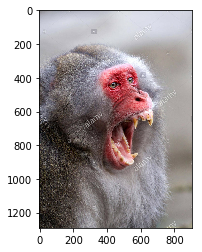

In [46]:
plt.imshow(result)